# Experiments with the environment classes

A number of experiments for finding the right parametrization of the environments for the benchmarks. 

__NOTE__: When this was created in 2022, the visualizations were only working in Jupyter notebook. As of April 2024, they also work in vscode.

In [1]:
# allow imports from the main source directory
import sys
sys.path.append('..')

import timeit
import time
import pathlib
import numpy as np
import random
import math
import shutil
from scipy import signal
import scipy
import matplotlib.pyplot as plt
from matplotlib import animation
from functools import partial


from IPython.display import display, HTML
plt.rcParams['figure.figsize'] = (5,3)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100
plt.rcParams["animation.html"] = "jshtml" 

from Environment import EpidemicSpreadEnvironment, DissipationModelEnvironment, SoilMoistureEnvironment, PrecalculatedEnvironment

# , animate_environment
from Helper import shifted_add, create_gaussian_hump

import logging
logging.basicConfig(level=logging.WARNING)

# NOTE: The animation with the %matplotlib inline works with independent 
# jupyter notebook, but NOT when running the notebook from vscode. 
# April 2024 - this appears to be fixed
%matplotlib inline


In [2]:
# A collection of helper functions for animating environments

def animate(env, axesimage, i):
    """Animates an environment by letting the environment proceed a timestep, then setting the values into image."""
    env.proceed(1.0)
    v = env.value.copy()
    axesimage.set_array(v)
    return [axesimage]

def animate_environment(env, frames=99, interval=5):
    """Creates an animated figure of the environment. Call plt.show after this. Interval specifies the speed of the animation."""
    fig, ax = plt.subplots()
    axesimage  = ax.imshow(env.value, vmin=0, vmax=1, cmap="gray")
    # Good try, but this doesn't work like this, it should be set from 
    # animate
    # ax.set_title(f"{env.name} time = {env.time}")
    anim = animation.FuncAnimation(fig, partial(animate, env, axesimage), 
                                       frames=frames, interval=interval, 
                                       blit=True)
    return anim


# EpidemicSpreadEnvironment
Visualize the evolution of the epidemic spread environment in time in a video. Adjust the parametrization as appropriate to try out different settings.

11


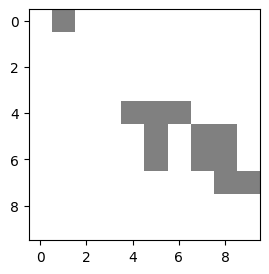

In [3]:
width = 10 # 1000
height = 10 # 2000
#spread_dimension = int(math.sqrt(width) / 6) * 2 + 3
spread_dimension = 11
print(spread_dimension)
infection_seeds = 3 * max(int(width / 30), 1)
p_transmission = 0.25
# seeds 1*, 0.15 looks good for ccr
# seeds 3*, 0.25 looks good for tylcv
env = EpidemicSpreadEnvironment("crop", width, height, seed=1, infection_duration = 5, 
                                p_transmission = p_transmission, spread_dimension=spread_dimension, 
                                infection_seeds = infection_seeds)
anim = animate_environment(env, frames=20, interval=200)
plt.show()
HTML(anim.to_html5_video())

11


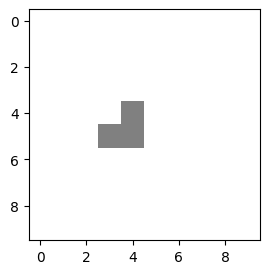

In [4]:
# Epidemic spread with immunity mask
width = 10 # 1000
height = 10 # 2000
immunity_mask = np.zeros((width, height))
for i in range(width):
    for j in range(2):
        immunity_mask[i, height // 2 + j] = -2.0

#spread_dimension = int(math.sqrt(width) / 6) * 2 + 3
spread_dimension = 11
print(spread_dimension)
infection_seeds = 1 # 3 * max(int(width / 30), 1)
p_transmission = 0.25
# seeds 1*, 0.15 looks good for ccr
# seeds 3*, 0.25 looks good for tylcv
env = EpidemicSpreadEnvironment("crop", width, height, seed=1, infection_duration = 5, 
                                p_transmission = p_transmission, spread_dimension=spread_dimension, 
                                infection_seeds = infection_seeds, immunity_mask=immunity_mask)
anim = animate_environment(env, frames=20, interval=200)
plt.show()
HTML(anim.to_html5_video())

# Soil moisture

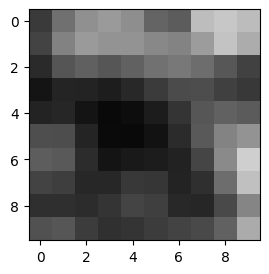

In [10]:
senv = SoilMoistureEnvironment("soil", 10, 10, seed=1, 
                               evaporation = 0.04, rainfall=0.06, rain_likelihood = 0.8)
# this only works in Jupyter notebook proper, not in vscode
anim = animate_environment(senv, frames=100, interval=100)
plt.show()
HTML(anim.to_html5_video())

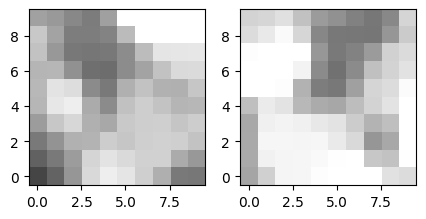

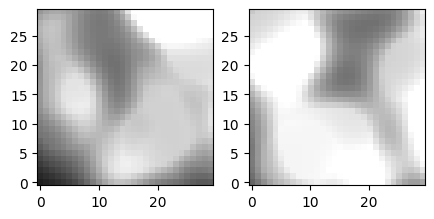

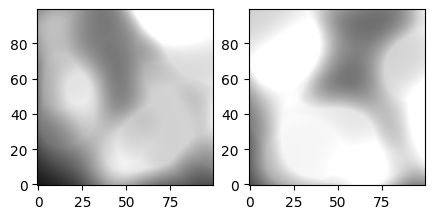

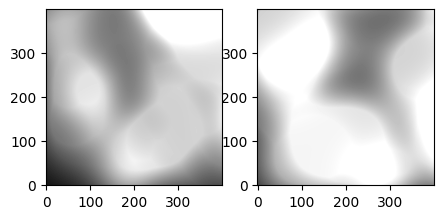

In [6]:
# experiment for Miniberry-10
seed = 3
for size in [10, 30, 100, 400]:
    senv = SoilMoistureEnvironment("soil", size, size, seed=seed, 
                                   evaporation = 0.04, rainfall=0.05, rain_likelihood = 0.8, warmup_time = 100)
    fig, (ax_0, ax_100) = plt.subplots(1,2)
    ax_0.imshow(senv.value, vmin=0, vmax=1, origin="lower", cmap="gray")
    for i in range(100):
        senv.proceed(1.0)
    ax_100.imshow(senv.value, vmin=0, vmax=1, origin="lower", cmap="gray")

## Testing the speed
Trying out different sizes of EpidemicSpreadEnvironment and DissipationModelEnvironment, and testing how long the creation and the proceed operation takes on them

In [7]:
for i in [10, 50, 100, 200, 400, 1000, 2000, 4000]:
    env = EpidemicSpreadEnvironment("crop", i, i, seed=40, infection_duration = 5, p_transmission = 0.1)
    env.status[i // 2, i // 2] = 2
    env.status[(3*i) // 4, (3*i) // 4] = 5
    timeval = timeit.timeit("env.proceed(1.0)", number=1, globals=globals())
    print(f"map of size {i}x{i} a proceed took {timeval:0.2} seconds")
# trying out different sizes of DissipationModelEnvironment
print("DissipationModelEnvironment")
for i in [10, 50, 100, 200, 400, 1000, 2000, 4000]:
    env = DissipationModelEnvironment("pollution", i, i, seed=40)
    # env.status[i // 2, i // 2] = 2
    # env.status[(3*i) // 4, (3*i) // 4] = 5
    timeval = timeit.timeit("env.proceed(1.0)", number=1, globals=globals())
    print(f"map of size {i}x{i} a proceed took {timeval:0.2} seconds")

map of size 10x10 a proceed took 0.00024 seconds
map of size 50x50 a proceed took 0.0012 seconds
map of size 100x100 a proceed took 0.0024 seconds
map of size 200x200 a proceed took 0.01 seconds
map of size 400x400 a proceed took 0.04 seconds
map of size 1000x1000 a proceed took 0.27 seconds
map of size 2000x2000 a proceed took 1.2 seconds
map of size 4000x4000 a proceed took 4.5 seconds
DissipationModelEnvironment
map of size 10x10 a proceed took 0.00014 seconds
map of size 50x50 a proceed took 0.00018 seconds
map of size 100x100 a proceed took 0.00057 seconds
map of size 200x200 a proceed took 0.0021 seconds
map of size 400x400 a proceed took 0.0084 seconds
map of size 1000x1000 a proceed took 0.031 seconds
map of size 2000x2000 a proceed took 0.19 seconds
map of size 4000x4000 a proceed took 0.61 seconds


# PrecalculatedEnvironment
Testing that we can create a PrecalculatedEnvironment with an EpidemicSpreadEnvironment embedded, save it, load it back and visualize it.

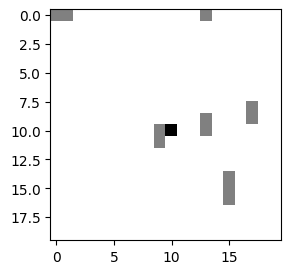

In [8]:
p = pathlib.Path.cwd().parent.parent.parent
#print(p)
savedir = pathlib.Path(p.parent, "__Temporary", p.name + "_data", "experiments")
#print(savedir)
savedir.mkdir(parents=True, exist_ok = True)
shutil.rmtree(savedir)
savedir.mkdir(parents=True, exist_ok = True)

height = 20 # was 2000
width = 20 # was 2000
env = EpidemicSpreadEnvironment("crop", width, height, seed=40, infection_duration = 5, p_transmission = 0.1)
env.status[width // 2, height // 2] = 2
env.status[(3*width) // 4, (3*height) // 4] = 5
precenv = PrecalculatedEnvironment(width,height, env, savedir)
for t in range(0, 100):
    precenv.proceed(1.0)

## reloading
pe = PrecalculatedEnvironment(width, height, None, savedir)
anim = animate_environment(pe)
plt.show()